# 랜덤포레스트
- 의사결정 트리
    - 높은 분산, 낮은 편향 => 모델의 안정성 떨어짐
- 랜덤포레스트
    - 의사결정 트리를 평균화 => 모델의 분산을 안정화
   
- 배깅 : 전체 테이블에서 소수의 관측값과 전체 열이 선택
- 랜덤포레스트 : 소수의 관측값과 열이 선택 => 서로 상관없는 개별 트리 생성

- 의사결정 트리의 앙상블 과정으로 인해 랜덤포레스트는 개별 변수에 관한 해석이 힘듬 => 변수의 유의성을 결정할 수 없음
- 따라서, 변수의 중요도만 제공됨

In [1]:
# 모듈 가져오기
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [2]:
# 데이터 불러오기
credit_data = pd.read_csv('./Data/german_credit_new.csv')

In [3]:
# 데이터 shap 확인
credit_data.shape

(1000, 21)

In [4]:
# 데이터 컬럼 확인
credit_data.columns

Index(['Status of existing checking account', 'Duration in month',
       'Credit history', 'Purpose', 'Credit amount', 'Savings account/bonds',
       'Present employment since',
       'Installment rate in percentage of disposable income',
       'Personal status and sex', 'Other debtors / guarantors',
       'Present residence since', 'Property', 'Age in years',
       'Other installment plans', 'Housing',
       'Number of existing credits at this bank', 'Job',
       'Number of people being liable to provide maintenance for', 'Telephone',
       'foreign worker', 'class'],
      dtype='object')

In [5]:
# 종속변수 class 1 ,2 를 -> 0, 1로 변환
credit_data['class'] = credit_data['class'] -1

In [6]:
# 명목형 변수와, 연속형 변수로 나눠서 컬럼을 정의하자
dtypes = credit_data.dtypes
continuous_columns = list()
discrete_columns = list()
for i in range(0, len(dtypes)):
    if dtypes[i] == 'object':
        discrete_columns.append(credit_data.columns[i])
        
    elif dtypes[i] == 'int64':
        continuous_columns.append(credit_data.columns[i])

In [7]:
# 컬럼 데이터 확인
print(continuous_columns)
print(discrete_columns)

['Duration in month', 'Credit amount', 'Installment rate in percentage of disposable income', 'Present residence since', 'Age in years', 'Number of existing credits at this bank', 'Number of people being liable to provide maintenance for', 'class']
['Status of existing checking account', 'Credit history', 'Purpose', 'Savings account/bonds', 'Present employment since', 'Personal status and sex', 'Other debtors / guarantors', 'Property', 'Other installment plans', 'Housing', 'Job', 'Telephone', 'foreign worker']


In [8]:
# 명목형 데이터는 더미 변수로 변환 필요
dummies_list = list()
for col in discrete_columns:
    dummies_list.append(pd.get_dummies(credit_data[col], prefix = col))

In [9]:
# 더비변수들을 이용해서 데이터프레임 새로 만들기
dummies_df = pd.concat(dummies_list, axis = 1)

In [10]:
# 데이터분석을 위한 새로운 통합 데이터 프레임 만들기
credit_data_new = pd.concat([credit_data[continuous_columns], dummies_df], axis = 1)

In [11]:
# 데이터 프레임 확인하기
credit_data_new

,Duration in month,Credit amount,Installment rate in percentage of disposable income,Present residence since,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for,class,Status of existing checking account_A11,Status of existing checking account_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,foreign worker_A201,foreign worker_A202
0,6,1169,4,4,67,2,1,0,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,1,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,0,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
996,30,3857,4,4,40,1,1,0,1,0,...,1,0,0,0,0,1,0,1,1,0
997,12,804,4,4,38,1,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0
998,45,1845,4,4,23,1,1,1,1,0,...,0,1,0,0,1,0,0,1,1,0


In [44]:
# train, test 데이터 분할하기
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
x_train, x_test, y_train, y_test = train_test_split(credit_data_new.drop('class', axis = 1), credit_data_new['class'], test_size = 0.3, random_state = 42)

In [45]:
# 데이터 분할 상태 확인하기
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((700, 61), (300, 61), (700,), (300,))

## 랜덤 포레스트 머신 러닝 모델

- 트리 개수 : 1000개
- 분할 기준 : 지니계수
- 각 트리의 최대 깊이 : 100
- 분할에 필요한 각 노드의 최소 관측값 : 3
- 트리 노드의 최소 관측값 수 : 2

In [14]:
# 모델 생성
rf_fit = RandomForestClassifier(n_estimators = 1000, criterion = 'gini', max_depth = 100, min_samples_split = 3, min_samples_leaf = 2, random_state = 43)
rf_fit.fit(x_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=1000, random_state=43)

In [15]:
# 예측값
y_pred = rf_fit.predict(x_train)

In [16]:
# 데이터 shpae 확인
y_train.shape, y_pred.shape

((700,), (700,))

In [17]:
# confusion matrix - validation
pd.crosstab(y_train, y_pred, rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,491,0
1,28,181


In [18]:
# 테스트 값
y_pred_test = rf_fit.predict(x_test)

In [19]:
# confusion matrix - test
pd.crosstab(y_test, y_pred_test, rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,197,12
1,59,32


In [20]:
# 정확도 - train
accuracy_score(y_train, y_pred)

0.96

In [21]:
# 정확도 - test
accuracy_score(y_test, y_pred_test)

0.7633333333333333

## 그리드 검색
- 트리개수 : (1000, 2000, 3000)
- 최대 깊이 : (100, 200, 300)
- 분할당 최소 표본 : (2, 3)
- 단말 노드의 최소 표본 : (1,2)
        

In [22]:
# 모듈 가져오기
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [30]:
# 파이프라인 및 파라미터 생성
pipeline = Pipeline([('clf', RandomForestClassifier(criterion = 'gini'))])
parameters = {
    'clf__n_estimators' : (1000, 2000, 3000),
    'clf__max_depth'    : (100,200,300),
    'clf__min_samples_split' : (2,3),
    'clf__min_samples_leaf' : (1,2)
}

In [31]:
# 5중교차검증을 이용한 그리드서치
grid_search = GridSearchCV(pipeline, parameters, n_jobs = -1, cv = 5, verbose = 1, scoring = 'accuracy')
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': (100, 200, 300),
                         'clf__min_samples_leaf': (1, 2),
                         'clf__min_samples_split': (2, 3),
                         'clf__n_estimators': (1000, 2000, 3000)},
             scoring='accuracy', verbose=1)

In [32]:
# best_score
grid_search.best_score_

0.7742857142857142

In [40]:
# best_parameters
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(param_name, best_parameters[param_name])

clf__max_depth 300
clf__min_samples_leaf 2
clf__min_samples_split 2
clf__n_estimators 1000


In [41]:
# 예측
predictions = grid_search.predict(x_test)

In [42]:
# 정확도 확인
round(accuracy_score(y_test, predictions),4)

0.7533

In [47]:
# classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       209
           1       0.71      0.32      0.44        91

    accuracy                           0.75       300
   macro avg       0.73      0.63      0.64       300
weighted avg       0.74      0.75      0.72       300



In [48]:
# confusion maxtrix
pd.crosstab(y_test, predictions, rownames = ['Acutaul'], colnames = ['Predicted'])

Predicted,0,1
Acutaul,,
0,197,12
1,62,29


## 변수 중요도 그래프
- 가장 중요한 변수들의 순서를 지니 값 감소의 평군에 따라 내림차순으로 정렬해서 나타냄
- 파이썬에서 grid_search에서는 변수 중요도 그래프 기능이 없다.
- 따라서, 단순 랜덤 포레스트 함수를 사용해서 grid_search를 통해 찾은 파라미터를 적용한다.

In [61]:
# 모듈 가져 오기
import matplotlib.pyplot as plt
import numpy as np
rf_fit_best = RandomForestClassifier(n_estimators = 1000, criterion = 'gini', max_depth = 300, min_samples_split = 3, min_samples_leaf = 1)
rf_fit_best.fit(x_train,y_train)

RandomForestClassifier(max_depth=300, min_samples_split=3, n_estimators=1000)

In [62]:
# 변수 중요도
importances = rf_fit_best.feature_importances_

In [63]:
# 데이터 확인
print(importances.shape, "\n", importances)

(61,) 
 [0.07683325 0.10115002 0.03436327 0.0313122  0.08308263 0.01818781
 0.00885457 0.03554646 0.01772781 0.00746143 0.04739704 0.01539172
 0.01061128 0.01450942 0.00907846 0.02635285 0.02155381 0.00731308
 0.00287415 0.01238776 0.01502817 0.00261535 0.00466876 0.00994322
 0.00105401 0.01103188 0.01946694 0.00832068 0.0067692  0.00517512
 0.0124184  0.01112675 0.0146428  0.01355337 0.01150098 0.01236823
 0.00599354 0.01415121 0.01433408 0.00790543 0.00959052 0.00628224
 0.00710823 0.0155016  0.01151679 0.01443799 0.01262812 0.01291416
 0.00552134 0.01489434 0.01001818 0.01571725 0.0086043  0.00253185
 0.00965254 0.01412211 0.01139411 0.01396575 0.01334639 0.00324055
 0.00295444]


In [67]:
# 표준편차 계산
std = np.std([tree.feature_importances_ for tree in rf_fit_best.estimators_], axis = 0)

In [83]:
# 인덱싱
indices = np.argsort(importances)[::-1] # 이거 무슨 문법이지 ?
indices

array([ 1,  4,  0, 10,  7,  2,  3, 15, 16, 26,  5,  8, 51, 43, 11, 20, 49,
       32, 13, 45, 38, 37, 55, 57, 33, 58, 47, 46, 30, 19, 35, 44, 34, 56,
       31, 25, 12, 50, 23, 54, 40, 14,  6, 52, 27, 39,  9, 17, 42, 28, 41,
       36, 48, 29, 22, 59, 60, 18, 21, 53, 24], dtype=int64)

In [84]:
colnames = list(x_train.columns)
for f in range(x_train.shape[1]):
    print('Feature', indices[f], ",", colnames[indices[f]], round(importances[indices[f]], 4))

Feature 1 , Credit amount 0.1012
Feature 4 , Age in years 0.0831
Feature 0 , Duration in month 0.0768
Feature 10 , Status of existing checking account_A14 0.0474
Feature 7 , Status of existing checking account_A11 0.0355
Feature 2 , Installment rate in percentage of disposable income 0.0344
Feature 3 , Present residence since 0.0313
Feature 15 , Credit history_A34 0.0264
Feature 16 , Purpose_A40 0.0216
Feature 26 , Savings account/bonds_A61 0.0195
Feature 5 , Number of existing credits at this bank 0.0182
Feature 8 , Status of existing checking account_A12 0.0177
Feature 51 , Housing_A152 0.0157
Feature 43 , Property_A121 0.0155
Feature 11 , Credit history_A30 0.0154
Feature 20 , Purpose_A43 0.015
Feature 49 , Other installment plans_A143 0.0149
Feature 32 , Present employment since_A72 0.0146
Feature 13 , Credit history_A32 0.0145
Feature 45 , Property_A123 0.0144
Feature 38 , Personal status and sex_A93 0.0143
Feature 37 , Personal status and sex_A92 0.0142
Feature 55 , Job_A173 0.01

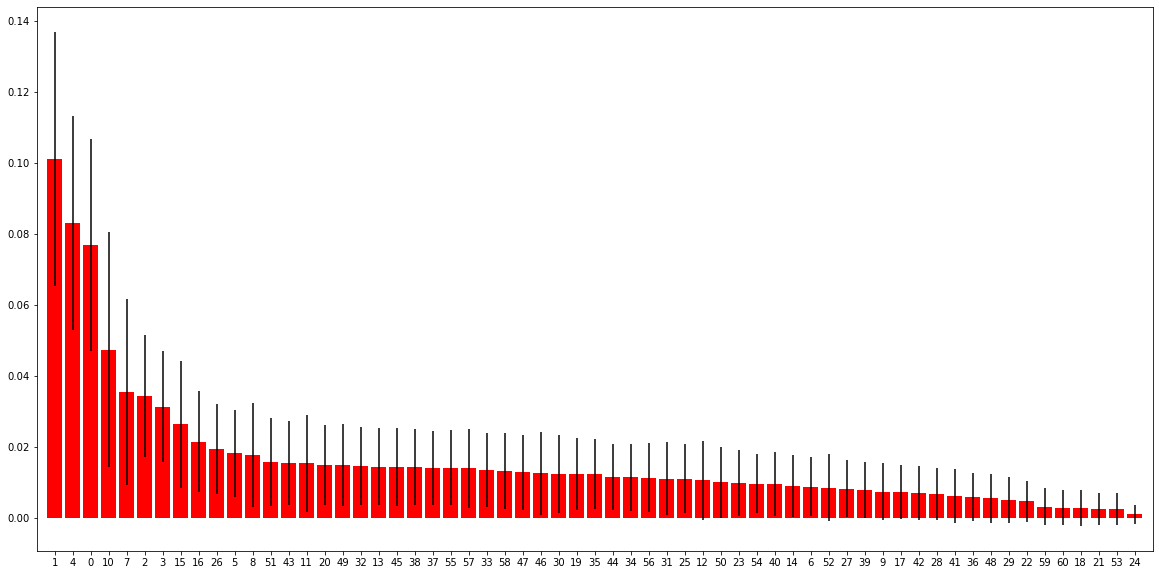

In [88]:
# 그래프 그리기
plt.figure(figsize=(20,10))
plt.bar(range(x_train.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
plt.xlim([-1, x_train.shape[1]])
plt.xticks(range(x_train.shape[1]), indices)
plt.show()